In [1]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv('/kaggle/input/igp-forecasting/IPG2211A2N.csv')
df.head()

,observation_date,IPG2211A2N
0,1939-01-01,3.3336
1,1939-02-01,3.3591
2,1939-03-01,3.4354
3,1939-04-01,3.4608
4,1939-05-01,3.4608


In [4]:
df.shape

(1030, 2)

# DATA PREPROCESSING

In [5]:
df.isnull().sum()

observation_date    0
IPG2211A2N          0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  1030 non-null   object 
 1   IPG2211A2N        1030 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


In [7]:
df['observation_date'] = pd.to_datetime(df['observation_date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  1030 non-null   datetime64[ns]
 1   IPG2211A2N        1030 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.2 KB


In [9]:
df.set_index('observation_date', inplace=True)

In [10]:
df.head()

,IPG2211A2N
observation_date,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608


# CHECK DATA STATIONARY

<Axes: xlabel='observation_date'>

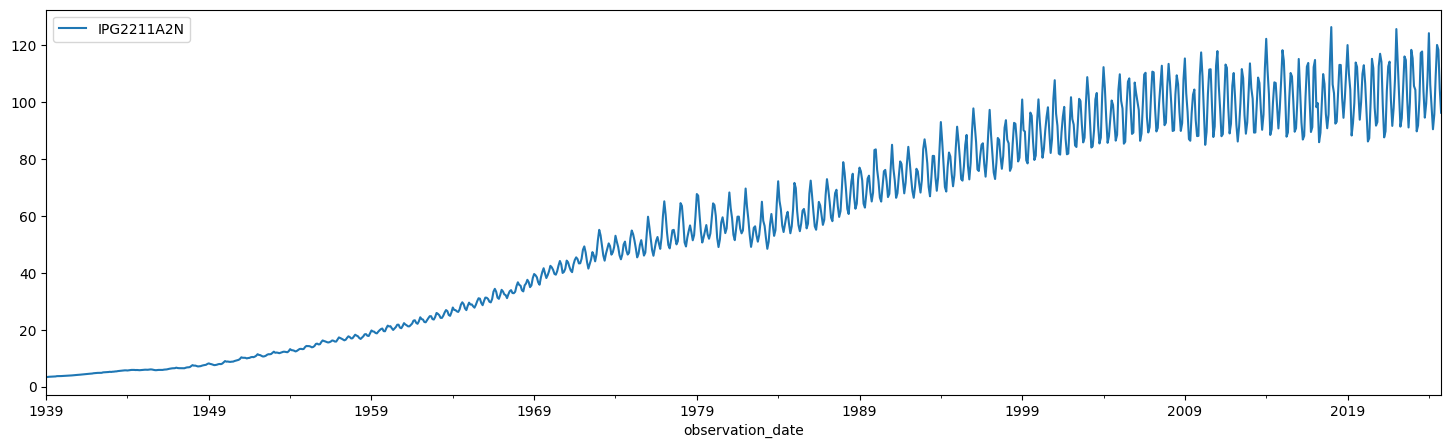

In [11]:
df.plot(figsize= (18,5))

In [12]:
#DICKEY FULLER TEST FOR MAKING DATA STAIONARY
def adf_test(data):
    result = adfuller(data)
    print(f'ADF Statistics: {result[0]}')
    print(f'P - Value: {result[1]}')
    if(result[1] <= 0.05):
        print('Reject the Null Hypothesis - Data is Stationary')
    else:
        print('Accept the Null Hypothesis - Data is not stationary')

In [13]:
adf_test(df.values)

ADF Statistics: -0.7144157341270445
P - Value: 0.8429801190131623
Accept the Null Hypothesis - Data is not stationary


In [14]:
#FIRST ORDER DIFFERENCING
df['first_order'] = df['IPG2211A2N'].diff() # IF 2ND OREDER DIFFERENCING WRITE 2 IN BRACKETS

In [15]:
df.head()

,IPG2211A2N,first_order
observation_date,,
1939-01-01,3.3336,NaN
1939-02-01,3.3591,0.0255
1939-03-01,3.4354,0.0763
1939-04-01,3.4608,0.0254
1939-05-01,3.4608,0.0000


In [16]:
df.dropna(inplace = True)

In [17]:
adf_test(df['first_order'])

ADF Statistics: -10.34561526534466
P - Value: 2.6158472034400057e-18
Reject the Null Hypothesis - Data is Stationary


<Axes: xlabel='observation_date'>

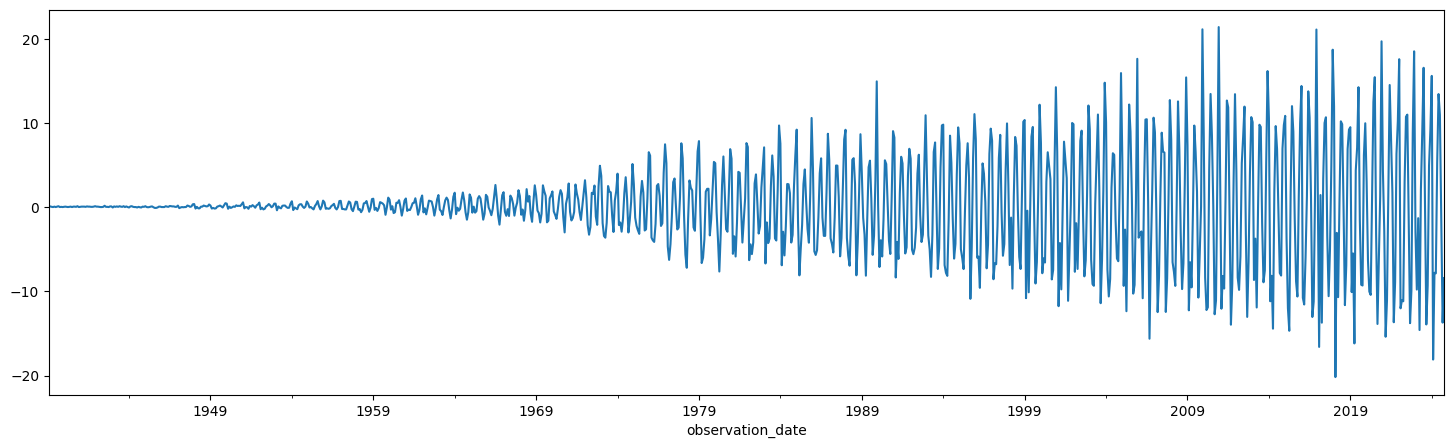

In [18]:
df['first_order'].plot(figsize = (18,5))

# TRAIN - TEST SPLIT

In [19]:
#WANT 80% FOR TRAIN
0.8*len(df)

823.2

In [20]:
train = df[['first_order']][:823] # 2 BRACKETS BEACUSE WITH ONE BRACKET IT WILL BE IN ARRAY FORM WE WANT IT IN DATAFRAME
test = df[['first_order']][823:]

In [21]:
train.shape, test.shape

((823, 1), (206, 1))

# DETERMINE ARIMA PARAMETERS p,d,q

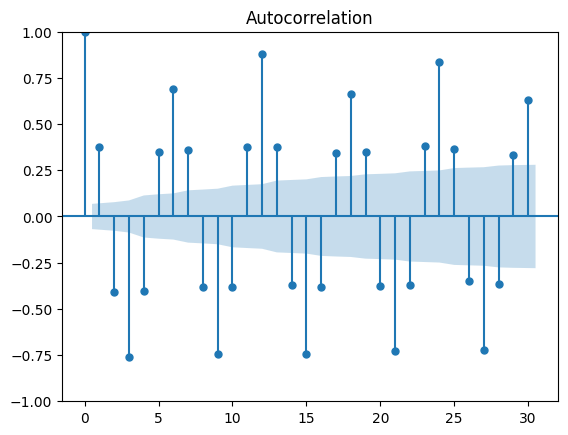

In [22]:
# ACF PLOT - q
acf = plot_acf(train.values)

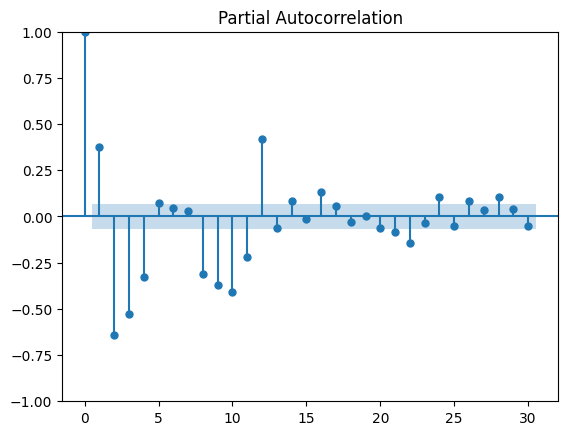

In [23]:
#PACF - p
pacf = plot_pacf(train.values)

In [24]:
autoarima = auto_arima(train, seasonal = False)

In [25]:
print(autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  823
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1766.063
Date:                Sat, 21 Dec 2024   AIC                           3544.126
Time:                        14:50:06   BIC                           3572.403
Sample:                    02-01-1939   HQIC                          3554.974
                         - 08-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1240      0.069      1.789      0.074      -0.012       0.260
ar.L1          1.0002      0.001    846.917      0.000       0.998       1.003
ar.L2         -0.9994      0.001  -1094.089      0.0

# BUILDING THE MODEL

In [26]:
model = ARIMA(train, order = autoarima.order)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='observation_date'>

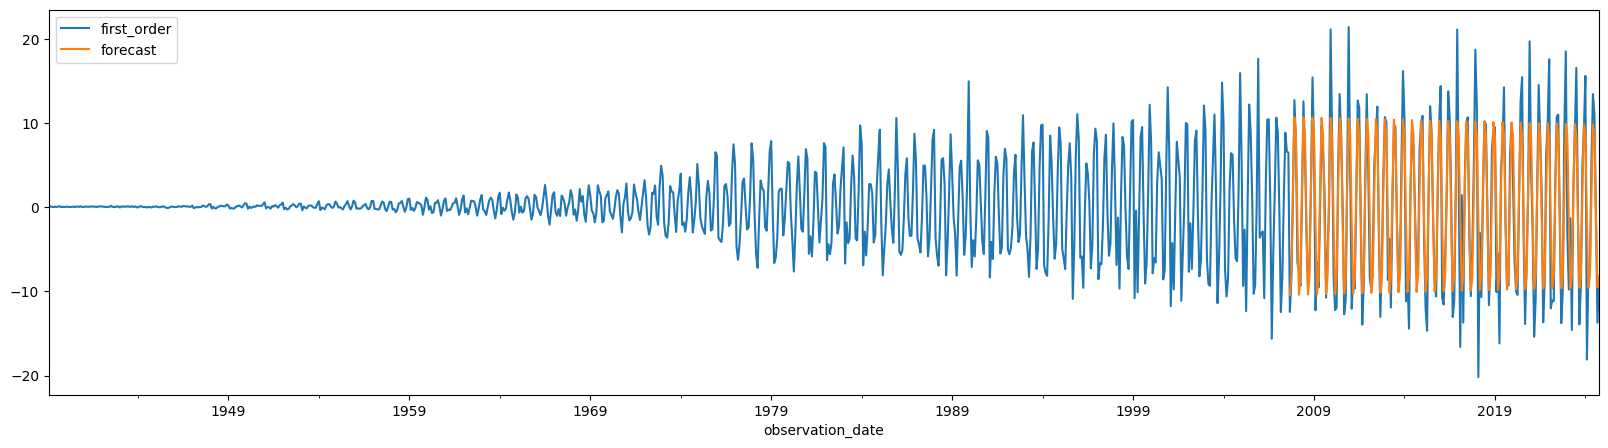

In [27]:
forecast = autoarima.predict(n_periods = len(test))

df['forecast'] = [None]*len(train) + list(forecast)
df[['first_order', 'forecast']].plot(figsize = (20,5))

In [28]:
df.head()

,IPG2211A2N,first_order,forecast
observation_date,,,
1939-02-01,3.3591,0.0255,NaN
1939-03-01,3.4354,0.0763,NaN
1939-04-01,3.4608,0.0254,NaN
1939-05-01,3.4608,0.0000,NaN
1939-06-01,3.5117,0.0509,NaN


# PLOTTING TEST RESULT

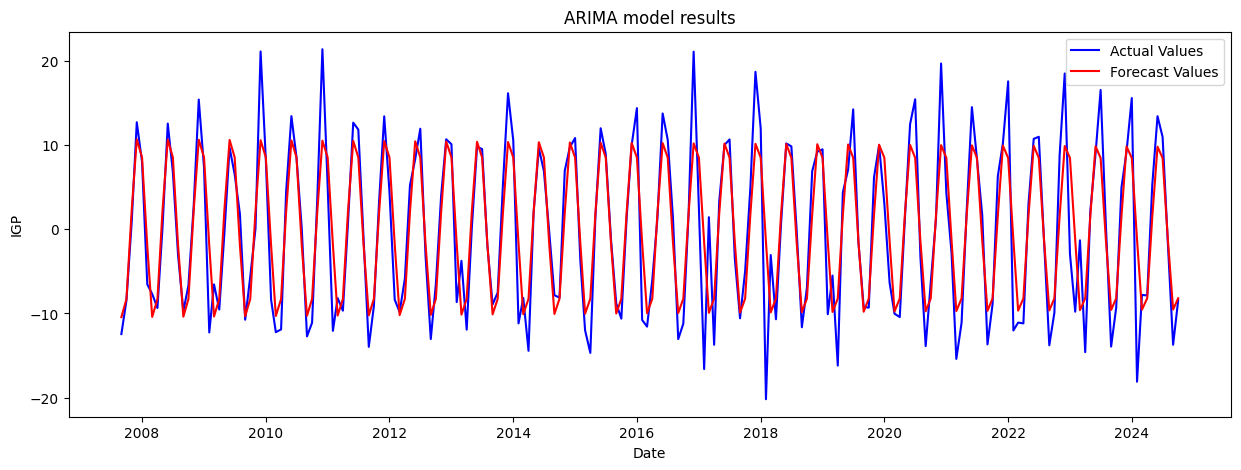

In [29]:
plt.figure(figsize = (15,5))
plt.plot(df['first_order'][823:], color = 'blue', label = 'Actual Values')
plt.plot(df['forecast'][823:], color = 'red', label = 'Forecast Values')
plt.title('ARIMA model results')
plt.xlabel('Date')
plt.ylabel('IGP')
plt.legend()

In [30]:
mae = mean_absolute_error(df['first_order'][823:], df['forecast'][823:])
rmse = np.sqrt(mean_absolute_error(df['first_order'][823:], df['forecast'][823:]))

print(f'Mean Absolute Error :{mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error :3.2260535520414693
Root Mean Squared Error: 1.796121808798465
